Test sur 10000 articles sur le thème "election" avec un dataset réduit aux labels, sources, titres et textes avec bert-base, en utilisant le tuto: https://huggingface.co/docs/transformers/v4.35.2/en/training et le tp de TAL.

C'est juste pour tester et avoir un modèle qui tourne/s'entraine bien, les résultats ne sont pas encore intéressants. Hesitez pas à changer le code si vous voulez corriger/tester des choses (en mettant des commentaires si possible)

In [ ]:
!pip install transformers[torch]
!pip install evaluate
!pip install datasets
!pip install huggingface_hub

In [ ]:
import datasets
import torch
import numpy as np
import evaluate
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

In [ ]:
##-- Récuperer l'extrait de données np-elec-10k
!wget "https://drive.google.com/uc?export=download&id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r" -O "np-elec-10k.csv"

--2024-01-24 16:42:14--  https://drive.google.com/uc?export=download&id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r
Resolving drive.google.com (drive.google.com)... 142.250.148.113, 142.250.148.138, 142.250.148.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.148.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r&export=download [following]
--2024-01-24 16:42:14--  https://drive.usercontent.google.com/download?id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.234.132, 2607:f8b0:4001:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.234.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51058529 (49M) [application/octet-stream]
Saving to: ‘np-elec-10k.csv’

np-elec-10k.csv     100%[===================>]  48.69M   10

In [ ]:
##--Importer les données dans un dataframe pandas

df = pd.read_csv("np-elec-10k.csv")  #dispo sur le drive

##--Renommer les colonnes qu'on va utiliser
df = df.rename(columns={ 'Allside': 'labels' })
df = df.rename(columns={ 'highlight.maintext': 'text' })
df = df.rename(columns={ '_source.title': 'title' })
df = df.rename(columns={'_source.source_domain': 'source'})

##--Selectionner les colonnes en question dans un nouveau dataframe
df2 = df[['labels','source','title','text']]

##--Supprimer les labels '?'
df3 = df2[df2['labels'] != '?']

##--Rennommer les labels avec des ints pour faciliter l'utilisation
correspondance = {"Left" :0, "Lean Left" :1, "Center" :2, "Lean Right" :3, "Right" :4, "Mixed" :5}
df3['labels'] = df3['labels'].replace(correspondance)

<ipython-input-17-7da3709eb7c0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['labels'] = df3['labels'].replace(correspondance)


In [ ]:
 ##-- Trouver les sources uniques dans le DataFrame
sources_uniques = df3['source'].unique()

##- Diviser la liste des sources de manière aléatoire en deux ensembles
sources_train, sources_test = train_test_split(sources_uniques, test_size=0.15, random_state=15)

##-- Filtrer les données en fonction des ensembles de sources
train_df = df3[df3['source'].isin(sources_train)]
test_df = df3[df3['source'].isin(sources_test)]

train_df2 = train_df[['labels','text']]
test_df2 = test_df[['labels','text']]

##--Separer les données dans des fichiers train et test
train_dataset = datasets.Dataset.from_pandas(train_df2)
test_dataset = datasets.Dataset.from_pandas(test_df2)

train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

##-- Exporter en csv pour verifier le ontenu des datasets
# train.to_csv('./splitm-elec/train.csv')
# test.to_csv('./splitm-elec/test.csv')

dataset = datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [ ]:
##-- Tokenisation

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000)) #Modifiez la range si vous voulez réduire le temps de training [0:6613]
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(200)) # [0:1202]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/6613 [00:00<?, ? examples/s]

Map:   0%|          | 0/1202 [00:00<?, ? examples/s]

In [ ]:
##-- Modele et entrainement

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)
training_args = TrainingArguments(output_dir="test_trainer")
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=small_train_dataset,

    eval_dataset=small_eval_dataset,

    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.026082,0.660000
2,0.893700,0.991386,0.625000
3,0.893700,1.331508,0.605000


TrainOutput(global_step=750, training_loss=0.7344708150227864, metrics={'train_runtime': 587.1066, 'train_samples_per_second': 10.22, 'train_steps_per_second': 1.277, 'total_flos': 1578723028992000.0, 'train_loss': 0.7344708150227864, 'epoch': 3.0})

In [ ]:
##-- Erreurs de prédiction

pred, p_labels, metrics = trainer.predict(small_eval_dataset)

q = 0
distance = []
t = len(small_eval_dataset[:]["labels"])
for i in range(len(small_eval_dataset[:]["labels"])):
  p = np.argmax(pred[i])
  if small_eval_dataset[i]["labels"] != p:
    q = q+1
    distance.append(np.abs(small_eval_dataset[i]["labels"]-p))
    print('texte n°: ',i,', label gold: ',small_eval_dataset[i]["labels"],', label predit:', p, 'distance:', np.abs(small_eval_dataset[i]["labels"]-p))

print("ratio: ",q,"/",t)
print("distance moyenne des erreurs :", np.mean(distance),"(sur 6 classes)")

texte n°:  3 , label gold:  1 , label predit: 2 distance: 1
texte n°:  5 , label gold:  4 , label predit: 1 distance: 3
texte n°:  6 , label gold:  4 , label predit: 0 distance: 4
texte n°:  7 , label gold:  1 , label predit: 2 distance: 1
texte n°:  13 , label gold:  1 , label predit: 0 distance: 1
texte n°:  15 , label gold:  1 , label predit: 4 distance: 3
texte n°:  19 , label gold:  1 , label predit: 2 distance: 1
texte n°:  20 , label gold:  1 , label predit: 2 distance: 1
texte n°:  21 , label gold:  1 , label predit: 0 distance: 1
texte n°:  22 , label gold:  1 , label predit: 2 distance: 1
texte n°:  27 , label gold:  1 , label predit: 2 distance: 1
texte n°:  28 , label gold:  1 , label predit: 0 distance: 1
texte n°:  29 , label gold:  1 , label predit: 2 distance: 1
texte n°:  30 , label gold:  4 , label predit: 1 distance: 3
texte n°:  32 , label gold:  1 , label predit: 2 distance: 1
texte n°:  34 , label gold:  1 , label predit: 0 distance: 1
texte n°:  50 , label gold: 

Première explication : CLS Explainer

In [ ]:
!pip install transformers_interpret

In [ ]:
from transformers_interpret import SequenceClassificationExplainer, TokenClassificationExplainer

In [ ]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

In [ ]:
cls_explainer(small_eval_dataset[1]["text"])
cls_explainer.visualize()

In [ ]:
from transformers import LongformerTokenizer, LongformerForMaskedLM

tokenizer_longformer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model_longformer = LongformerForMaskedLM.from_pretrained("allenai/longformer-base-4096")


In [ ]:
from torch.nn import Softmax

In [ ]:
import json

In [ ]:
input_text = test_df2.iloc[0]['text']

txt = input_text.split()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for i in range(832, len(txt)):
  print(f"{i}/{len(txt)}")
  #Partie où on remplace le mots du text par un mask et on prédie avec longformer le mot le plus probable
  cloned_txt = txt[:]
  cloned_txt[i] = '<mask>';

  input_ids = tokenizer_longformer([str(' '.join(cloned_txt))], return_tensors="pt")["input_ids"]
  logits = model_longformer(input_ids).logits

  masked_index = (input_ids[0] == tokenizer_longformer.mask_token_id).nonzero().item()
  probs = logits[0, masked_index].softmax(dim=0)
  values, predictions = probs.topk(5)

  tokens_predicted = tokenizer_longformer.decode(predictions).split()
  if len(tokens_predicted) >= 3:
    new_txt = ' '.join(cloned_txt).replace('<mask>', tokens_predicted[2])
  else:
    new_txt = ' '.join(cloned_txt).replace('<mask>', tokens_predicted[0])

  #Partie où on va maintenant regarder la classe prédite et la certitude avec le mot altéré

  tokenized_input = tokenizer(new_txt, return_tensors="pt", padding=True, truncation=True).to(device)

  with torch.no_grad():
      logits = model(**tokenized_input).logits

  probabilities = Softmax(dim=1)(logits)
  predicted_class = torch.argmax(logits, dim=1).item()
  confidence = probabilities[0, predicted_class].item()

  #Maitenant on va stocké cette information

  results.append({"predicted_class": predicted_class, "confidence": confidence})

  with open("results.txt", 'w') as fichier:
      # Écrire la valeur de la variable dans le fichier
      fichier.write(json.dumps(results, indent=2))

In [ ]:
with open("results.txt", 'r') as fichier:
    donnees_results = json.load(fichier)

print(donnees_results)

[{'predicted_class': 1, 'confidence': 0.9754326939582825}, {'predicted_class': 1, 'confidence': 0.9605919122695923}, {'predicted_class': 1, 'confidence': 0.9850431680679321}, {'predicted_class': 0, 'confidence': 0.9721496105194092}, {'predicted_class': 1, 'confidence': 0.9819433093070984}, {'predicted_class': 1, 'confidence': 0.9667093753814697}, {'predicted_class': 1, 'confidence': 0.976757824420929}, {'predicted_class': 1, 'confidence': 0.9640953540802002}, {'predicted_class': 1, 'confidence': 0.9829509854316711}, {'predicted_class': 1, 'confidence': 0.9823434352874756}, {'predicted_class': 1, 'confidence': 0.9762099385261536}, {'predicted_class': 1, 'confidence': 0.9766266942024231}, {'predicted_class': 1, 'confidence': 0.9758813977241516}, {'predicted_class': 1, 'confidence': 0.9831884503364563}, {'predicted_class': 1, 'confidence': 0.9762149453163147}, {'predicted_class': 1, 'confidence': 0.9796899557113647}, {'predicted_class': 1, 'confidence': 0.977889358997345}, {'predicted_cla

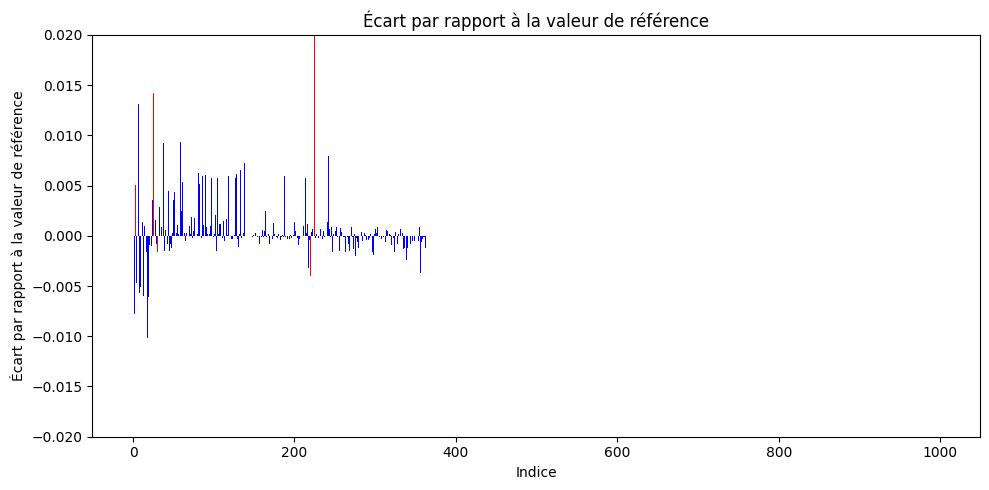

In [ ]:
import matplotlib.pyplot as plt

# Valeur de référence
valeur_reference = 0.9772276282310486

# Extraire les indices, les confiances et les classes pour les 200 premiers éléments
indices = range(len(donnees_results))
confiances = [valeur_reference - element['confidence'] for element in donnees_results]
classes = [element['predicted_class'] for element in donnees_results]

# Créer un graphique à barres
fig, ax = plt.subplots(figsize=(10, 5))
barres = ax.bar(indices, confiances, color=['red' if classe == 0 else 'blue' for classe in classes])

# Ajouter des étiquettes
ax.set_xlabel('Indice')
ax.set_ylabel('Écart par rapport à la valeur de référence')
ax.set_title('Écart par rapport à la valeur de référence')
ax.set_ylim(-0.02, 0.02)
# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
indice_confidence_sup_1 = []

for indice, element in enumerate(donnees_results):
    if element['predicted_class'] == 0:
        indice_confidence_sup_1.append(indice)

In [ ]:
print(indice_confidence_sup_1)

[3, 25, 30, 220, 225]


In [ ]:
for i in indice_confidence_sup_1:
  print(test_df2.iloc[0]['text'].split()[i])

voters
—
—
Pennsylvania
states


In [ ]:
indice_confidence_sup_1 = []

for indice, element in enumerate(donnees_results):
    if element['confidence'] < 0.95:
        indice_confidence_sup_1.append(indice)

In [ ]:
print(indice_confidence_sup_1)

[225]


In [ ]:
print(test_df2.iloc[0]['text'])

A lot of voters are asking these questions right now: How quickly will ballots be counted in the presidential **election**? Which states will have results — and possibly a winner — on **election** night?
In a year when absentee ballots are surging, a lot depends on when officials first start what’s called pre-processing of ballots. This ranges from verifying signatures, opening envelopes and flattening ballots to get them ready for tabulation.
When mail and absentee ballots are pre-processed Upon receipt AZ GA MN NV AK CO DC HI ID IL IN KS MA MT NE NJ NY SD TN UT VA WA Before **Election** Day FL IA MI NH NC OH AR CA CT DE KY LA ME MD MO NM ND OK OR RI SC TX VT WV WY On **Election** Day PA WI AL MS Key presidential battleground
Some states begin this work weeks in advance and others are only allowed to begin on **Election** Day. States that begin early may have a lot more results counted by **election** night.
Because of the surge in mail ballots that need to be counted, if the presiden